In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

#from jax.experimental import stax
from jax.example_libraries import stax
from jax.example_libraries import optimizers
#from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

def lagrangian(q, q_dot, m1, m2, l1, l2, g):
    t1, t2 = q     # theta 1 and theta 2
    w1, w2 = q_dot # omega 1 and omega 2

      # kinetic energy (T)
    T1 = 0.5 * m1 * (l1 * w1)**2
    T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                        2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
    T = T1 + T2

      # potential energy (V)
    y1 = -l1 * jnp.cos(t1)
    y2 = y1 - l2 * jnp.cos(t2)
    V = m1 * g * y1 + m2 * g * y2

    return T - V

def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
    t1, t2, w1, w2 = state
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
    a2 = (l1 / l2) * jnp.cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
    (g / l1) * jnp.sin(t1)
    f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2)
    return jnp.stack([w1, w2, g1, g2])

def equation_of_motion(lagrangian, state, t=None):
    q, q_t = jnp.split(state, 2)
    q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
    return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
    @partial(jax.jit, backend='cpu')
    def f(initial_state):
        return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
    return f(initial_state)

# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
    L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
    return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
    return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
    k1 = h * f(x, t)
    k2 = h * f(x + k1/2, t + h/2)
    k3 = h * f(x + k2/2, t + h/2)
    k4 = h * f(x + k3, t + h)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [2]:
time_step = 0.01
N = 1500
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.arange(N, dtype=np.float32) # time steps 0 to N
%time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state
%time y_train = jax.device_get(analytical_step(x_train)) # analytical next step

noise = np.random.RandomState(0).randn(x0.size)
t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N
%time x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
%time xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state
%time y_test = jax.device_get(analytical_step(x_test)) # analytical next step


Wall time: 14.6 s
Wall time: 593 ms
Wall time: 357 ms
Wall time: 12.2 s
Wall time: 32 ms
Wall time: 2 ms


In [3]:
x_train

array([[  1.3463968 ,   2.3561945 ,   0.        ,   0.        ],
       [ -0.42738596,  -1.1811652 ,  -4.666162  ,  -0.6331832 ],
       [ -1.2464664 ,  -0.41254652,   4.414249  ,  -0.6399537 ],
       ...,
       [ -0.5972006 , -11.004961  ,  -0.41106147,  -6.7380757 ],
       [  0.22743227, -18.732622  ,   6.1493716 , -11.538839  ],
       [ -0.9150459 , -25.521055  ,   5.75344   ,  -8.23622   ]],
      dtype=float32)

In [8]:
xt_train

array([[  0.        ,   0.        ,  -8.982128  ,  -2.1508665 ],
       [ -4.666162  ,  -0.6331832 ,  -6.5546126 ,  28.74597   ],
       [  4.414249  ,  -0.6399537 ,  16.75101   , -21.757532  ],
       ...,
       [ -0.41106147,  -6.7380757 ,  25.578194  ,   4.244028  ],
       [  6.1493716 , -11.538839  , -21.844263  ,  24.737675  ],
       [  5.75344   ,  -8.23622   ,  48.54559   , -54.895676  ]],
      dtype=float32)

In [32]:
import numpy as np

# Dane wejściowe w postaci tablicy NumPy
input_array = np.array([[ 0.        ,  0.        , -8.982128  , -2.1508665 ],
                        [-4.666162  , -0.6331832 , -6.5546126 , 28.74597   ]])

def reshape_array(input_array):
    reshaped_array = input_array[:, 2:]  # Zachowaj tylko pierwsze dwa elementy z każdego wiersza
    return reshaped_array

In [27]:
acceleration = reshape_array(xt_train)

In [28]:
acceleration

array([[ -8.982128 ,  -2.1508665],
       [ -6.5546126,  28.74597  ],
       [ 16.75101  , -21.757532 ],
       ...,
       [ 25.578194 ,   4.244028 ],
       [-21.844263 ,  24.737675 ],
       [ 48.54559  , -54.895676 ]], dtype=float32)

In [30]:
data=np.concatenate((x_train, acceleration), axis=1)

In [31]:
data

array([[  1.3463968 ,   2.3561945 ,   0.        ,   0.        ,
         -8.982128  ,  -2.1508665 ],
       [ -0.42738596,  -1.1811652 ,  -4.666162  ,  -0.6331832 ,
         -6.5546126 ,  28.74597   ],
       [ -1.2464664 ,  -0.41254652,   4.414249  ,  -0.6399537 ,
         16.75101   , -21.757532  ],
       ...,
       [ -0.5972006 , -11.004961  ,  -0.41106147,  -6.7380757 ,
         25.578194  ,   4.244028  ],
       [  0.22743227, -18.732622  ,   6.1493716 , -11.538839  ,
        -21.844263  ,  24.737675  ],
       [ -0.9150459 , -25.521055  ,   5.75344   ,  -8.23622   ,
         48.54559   , -54.895676  ]], dtype=float32)

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

# Zakładamy, że masz dane w formie tablicy NumPy
# Przygotowanie danych (zmień na swoją tablicę numpy)
#data = np.random.rand(1000, 6)  # Przykładowe dane, zastąp to swoimi danymi

# Normalizacja danych
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Tworzenie sekwencji danych
sequence_length = 50  # Długość sekwencji wejściowej

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

X, y = create_sequences(scaled_data, sequence_length)

# Podział na zbiór treningowy i testowy
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4544      
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 4,934
Trainable params: 4,934
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
37/37 [==============================] - 4s 34ms/step - loss: 0.1073 - val_loss: 0.0765
Epoch 2/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0452 - val_loss: 0.0598
Epoch 3/20
37/37 [==============================] - 1s 20ms/step - loss: 0.0366 - val_loss: 0.0445
Epoch 4/20
37/37 [==============================] - 1s 21ms/step - loss: 0.0316 - val_loss: 0.0369
Epoch 5/20
37/37 [==============================] - 1s

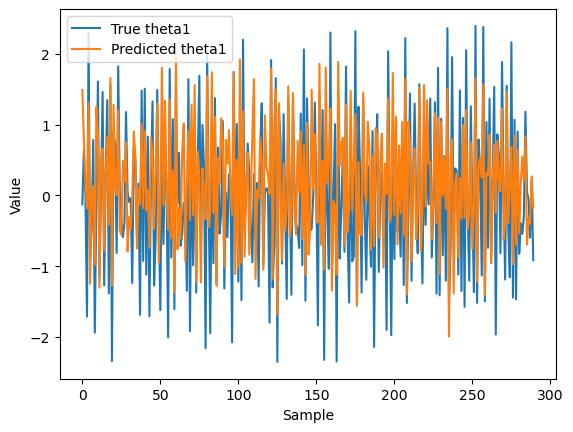

In [34]:
# Budowa modelu RNN
model = Sequential()
model.add(SimpleRNN(64, input_shape=(sequence_length, 6), return_sequences=False))
model.add(Dense(6))  # Wyjście: 6 zmiennych (2 kąty, 2 prędkości, 2 przyspieszenia)

model.compile(optimizer='adam', loss='mse')
model.summary()

# Trenowanie modelu
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Testowanie modelu
predicted_trajectory = model.predict(X_test)

# Inwersja skali dla wyników
predicted_trajectory = scaler.inverse_transform(predicted_trajectory)
y_test = scaler.inverse_transform(y_test)

# Wyświetlanie wyników
import matplotlib.pyplot as plt

# Przykładowe wyświetlenie dla pierwszego kąta
plt.plot(y_test[:, 0], label='True theta1')
plt.plot(predicted_trajectory[:, 0], label='Predicted theta1')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

In [36]:
def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1, y1, x2, y2 = cart_coords
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

In [42]:
predicted_trajectory[:, 1].size

290

0/290
1/290 2/290 3/290 4/290 5/290 6/290 7/290 8/290 9/290 10/290 11/290 12/290 13/290 14/290 15/290 16/290 17/290 18/290 19/290 20/290
21/290 22/290 23/290 24/290 25/290 26/290 27/290 28/290 29/290 30/290 31/290 32/290 33/290 34/290 35/290 36/290 37/290 38/290 39/290 40/290
41/290 42/290 43/290 44/290 45/290 46/290 47/290 48/290 49/290 50/290 51/290 52/290 53/290 54/290 55/290 56/290 57/290 58/290 59/290 60/290
61/290 62/290 63/290 64/290 65/290 66/290 67/290 68/290 69/290 70/290 71/290 72/290 73/290 74/290 75/290 76/290 77/290 78/290 79/290 80/290
81/290 82/290 83/290 84/290 85/290 86/290 87/290 88/290 89/290 90/290 91/290 92/290 93/290 94/290 95/290 96/290 97/290 98/290 99/290 100/290
101/290 102/290 103/290 104/290 105/290 106/290 107/290 108/290 109/290 110/290 111/290 112/290 113/290 114/290 115/290 116/290 117/290 118/290 119/290 120/290
121/290 122/290 123/290 124/290 125/290 126/290 127/290 128/290 129/290 130/290 131/290 132/290 133/290 134/290 135/290 136/290 137/290 138/29

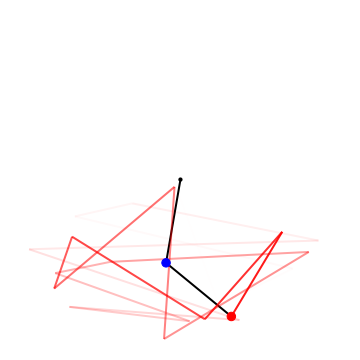

In [43]:
L1, L2 = 1, 1
theta1, theta2 = predicted_trajectory[:, 0], predicted_trajectory[:, 1]
cart_coords = radial2cartesian(theta1, theta2, L1, L2)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 290
for i in range(0, N, di):
  print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, L1, L2)
  images.append( fig2image(fig) )

In [44]:
import importlib
importlib.reload(proglog)
print("Base-predicted dynamics of the double pendulum:")
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip(images, fps=25).ipython_display()

Base-predicted dynamics of the double pendulum:
